# Chapter 5
### Distance based correlation analysis

In [2]:
#import packages
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import datetime as dt


import folium

import seaborn as sns


### GeoData
The location of bus/train stops are taken from the following link and processed in QGIS. <br>
The nearest point (Stop or green filed) to the store has been selected. <br>
QGIS > Processing tools > Distance to nearest hub <br>

https://www.vrs.de/fahren/fahrplanauskunft/opendata-/-openservice <br>

Green fields data is dowloaded from https://offenedaten-koeln.de/dataset/gruenflaechenkataster-koeln-flaechentypen <br>
The distances between the stores and the fields are calculated in QGIS. 



In [22]:
co_store_delta=gpd.read_file('../data/co_store_delta.geojson').set_index('Id').to_crs(5676)
#%store -r co_store_delta
co_store_delta=co_store_delta.to_crs(5676)
bus_distance=gpd.read_file('../data/Bus_stop_distance.geojson').set_index('Id')['HubDist']
stadtbahn_distance=gpd.read_file('../data/Stadtbahn_stop_distance.geojson').set_index('Id')['HubDist']
eisenbahn_distance=gpd.read_file('../data/Eisenbahn_stop_distance.geojson').set_index('Id')['HubDist']
greenfield_distance=gpd.read_file('../data/store_greenfield_distance.geojson').set_index('Id')['distance'].drop_duplicates()
node_degree=gpd.read_file('../data/nx_node_df.geojson', index_col='vertex').set_index('vertex')[['in_degree','out_degree']]


In [23]:
node_degree

,in_degree,out_degree
vertex,,
632c5d83-6266-4f57-be97-b60154a9464d,5.0,4.0
cdd31b00-ed5e-4972-ae6f-3b516c1f86bc,929.0,923.0
e20e6c15-6507-4427-8b68-e1d1f870b924,4336.0,4915.0
3e7a6e35-600e-4708-b637-1af73820b71b,1096.0,1343.0
fe940c48-04c7-43ba-948e-02c82d786915,1930.0,1598.0
...,...,...
73d68c13-ac9d-4298-8e7d-88e5711520a9,0.0,1.0
d2ebbf53-5f8b-4b50-bd90-25d9495688b3,0.0,45.0
cc5904e2-8805-460d-9974-2013e273593f,0.0,11.0


In [24]:
co_store_delta.index.is_unique

True

In [25]:
co_store_delta.head()

,MerchantId,Name,Longitude,Latitude,CreationDate,CategoryId,StreetAddress,City,SellsOfflineCards,check_ins,check_outs,delta,cater_in,cater_out,cater_delta,cater_out_ratio,geometry
Id,,,,,,,,,,,,,,,,,
37750976-cd54-44a5-a05a-d85d3cc9035b,2c1b374d-3d05-4b74-a260-a479c8ef9232,Krua Thai 2 - Heumarkt,6.960161,50.935471,2020-10-20T20:04:31.643000+02:00,2,Heumarkt 25,Köln,False,4607.0,-5932.0,-1325.0,6.0,0.0,6.0,-0.0,POINT (2567537.344 5644907.201)
d4e38d94-eb54-4049-b721-4da7c79f3891,2c9fdbe4-3e32-4916-ba19-147258d0dd1d,Fenster zum Hof,6.944754,50.948689,2019-09-22T21:53:24.931000+02:00,2,Im Mediapark 5,Köln,False,60.0,-47.0,13.0,0.0,0.0,0.0,-0.0,POINT (2566435.535 5646363.617)
74c987fb-9af6-4ea7-aaa8-413edbef6ee6,6d28a31d-9a71-4f95-8452-83c187e8fcbc,Mandalay,6.934454,50.937788,2021-04-27T14:14:10.912000+02:00,2,Brüsseler Straße 53,Köln,False,174.0,-242.0,-68.0,0.0,0.0,0.0,-0.0,POINT (2565727.114 5645141.785)
2b27f29f-d62f-4272-a4e5-b0c2605be351,ae5aee84-9e09-4cd0-b3be-7b99b98c200f,Flavour of India,6.936858,50.936587,2019-12-20T10:00:43.314999+01:00,2,Aachener Str. 16,Köln,False,2.0,-4.0,-2.0,0.0,0.0,0.0,-0.0,POINT (2565897.736 5645010.255)
ea6640b6-7407-4a04-b989-328ecc9ce341,e8bf52f0-f2de-445a-96bf-df387f14f8bf,01_R04_Cologne_Warehouse,6.894071,50.948646,2022-01-04T13:46:17.243999+01:00,10,Maarweg 251B,Köln,False,1776.0,-6091.0,-4315.0,0.0,0.0,0.0,-0.0,POINT (2562873.955 5646314.425)


In [26]:
co_store_delta.shape

(377, 17)

In [27]:
co_store_delta['bus_stop_distance']=bus_distance
co_store_delta['stadtbahn_stop_distance']=stadtbahn_distance
co_store_delta['eisenbahn_stop_distance']=eisenbahn_distance
co_store_delta['greenfield_distance']=greenfield_distance

In [28]:
co_store_delta.head()

,MerchantId,Name,Longitude,Latitude,CreationDate,CategoryId,StreetAddress,City,SellsOfflineCards,check_ins,...,delta,cater_in,cater_out,cater_delta,cater_out_ratio,geometry,bus_stop_distance,stadtbahn_stop_distance,eisenbahn_stop_distance,greenfield_distance
Id,,,,,,,,,,,,,,,,,,,,,
37750976-cd54-44a5-a05a-d85d3cc9035b,2c1b374d-3d05-4b74-a260-a479c8ef9232,Krua Thai 2 - Heumarkt,6.960161,50.935471,2020-10-20T20:04:31.643000+02:00,2,Heumarkt 25,Köln,False,4607.0,...,-1325.0,6.0,0.0,6.0,-0.0,POINT (2567537.344 5644907.201),31.800235,29.500703,842.590426,192.891699
d4e38d94-eb54-4049-b721-4da7c79f3891,2c9fdbe4-3e32-4916-ba19-147258d0dd1d,Fenster zum Hof,6.944754,50.948689,2019-09-22T21:53:24.931000+02:00,2,Im Mediapark 5,Köln,False,60.0,...,13.0,0.0,0.0,0.0,-0.0,POINT (2566435.535 5646363.617),735.037658,471.017426,537.127554,79.721550
74c987fb-9af6-4ea7-aaa8-413edbef6ee6,6d28a31d-9a71-4f95-8452-83c187e8fcbc,Mandalay,6.934454,50.937788,2021-04-27T14:14:10.912000+02:00,2,Brüsseler Straße 53,Köln,False,174.0,...,-68.0,0.0,0.0,0.0,-0.0,POINT (2565727.114 5645141.785),223.424468,172.736233,526.542322,58.282785
2b27f29f-d62f-4272-a4e5-b0c2605be351,ae5aee84-9e09-4cd0-b3be-7b99b98c200f,Flavour of India,6.936858,50.936587,2019-12-20T10:00:43.314999+01:00,2,Aachener Str. 16,Köln,False,2.0,...,-2.0,0.0,0.0,0.0,-0.0,POINT (2565897.736 5645010.255),172.902256,181.487062,702.473457,271.128063
ea6640b6-7407-4a04-b989-328ecc9ce341,e8bf52f0-f2de-445a-96bf-df387f14f8bf,01_R04_Cologne_Warehouse,6.894071,50.948646,2022-01-04T13:46:17.243999+01:00,10,Maarweg 251B,Köln,False,1776.0,...,-4315.0,0.0,0.0,0.0,-0.0,POINT (2562873.955 5646314.425),287.922319,1259.611959,400.081805,211.456936


In [29]:
co_store_delta=co_store_delta.join(node_degree[['in_degree','out_degree']], how='left')

In [30]:
co_store_delta[['in_degree', 'out_degree']]=co_store_delta[['in_degree', 'out_degree']].fillna(0)

In [31]:
vdf=co_store_delta

In [32]:
vdf['nearest_stop']=vdf[['stadtbahn_stop_distance','eisenbahn_stop_distance','bus_stop_distance']].min(axis=1)

In [33]:
vdf[vdf['in_degree']<0]

,MerchantId,Name,Longitude,Latitude,CreationDate,CategoryId,StreetAddress,City,SellsOfflineCards,check_ins,...,cater_delta,cater_out_ratio,geometry,bus_stop_distance,stadtbahn_stop_distance,eisenbahn_stop_distance,greenfield_distance,in_degree,out_degree,nearest_stop
Id,,,,,,,,,,,,,,,,,,,,,


In [34]:
map_osm = folium.Map(location=[50.93, 6.91],zoom_start=11)
for ind, row in vdf[vdf['check_ins'].isna()].iterrows():
    if row['delta']<-500: color='red'
    elif row['delta']<-100: color='orange'
    elif row['delta']<0: color='yellow' 
    elif row['delta']>0: color='limegreen'
    elif row['delta']>100: color='green'
    elif row['delta']>500: color='darkgreen'
    else: color='green'
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],radius=2, popup=ind, color=color).add_to(map_osm)
map_osm

## Correlation

In [35]:
df=vdf[['check_ins','check_outs','in_degree','out_degree',\
        'nearest_stop', \
        'greenfield_distance']].fillna(0)
df.corr()

,check_ins,check_outs,in_degree,out_degree,nearest_stop,greenfield_distance
check_ins,1.000000,-0.979255,0.878944,0.859389,-0.018834,-0.022690
check_outs,-0.979255,1.000000,-0.845068,-0.860971,-0.001699,0.004631
in_degree,0.878944,-0.845068,1.000000,0.973621,-0.019819,-0.033600
out_degree,0.859389,-0.860971,0.973621,1.000000,0.006808,-0.015688
nearest_stop,-0.018834,-0.001699,-0.019819,0.006808,1.000000,0.286270
greenfield_distance,-0.022690,0.004631,-0.033600,-0.015688,0.286270,1.000000


In [36]:
from scipy.stats import pearsonr
p_val = np.zeros(shape=(df.shape[1],df.shape[1]))
cor=np.zeros(shape=(df.shape[1],df.shape[1]))
for c in range(len(list(df.columns))):
    for i in range(len(list(df.columns))):
        
            cor_,p_value_=pearsonr(df.iloc[:,c],df.iloc[:,i])
            p_val[c,i]=p_value_
            cor[c,i]=cor_
p_val_df=pd.DataFrame(p_val, columns=df.columns, index=df.columns).round(decimals=3)# p_values
p_val_df # p-value

,check_ins,check_outs,in_degree,out_degree,nearest_stop,greenfield_distance
check_ins,0.000,0.000,0.000,0.000,0.715,0.661
check_outs,0.000,0.000,0.000,0.000,0.974,0.929
in_degree,0.000,0.000,0.000,0.000,0.701,0.515
out_degree,0.000,0.000,0.000,0.000,0.895,0.761
nearest_stop,0.715,0.974,0.701,0.895,0.000,0.000
greenfield_distance,0.661,0.929,0.515,0.761,0.000,0.000


In [37]:
corr_df=pd.DataFrame(cor, columns=df.columns, index=df.columns).round(decimals=3)# corr matrix
corr_df # correlation

,check_ins,check_outs,in_degree,out_degree,nearest_stop,greenfield_distance
check_ins,1.000,-0.979,0.879,0.859,-0.019,-0.023
check_outs,-0.979,1.000,-0.845,-0.861,-0.002,0.005
in_degree,0.879,-0.845,1.000,0.974,-0.020,-0.034
out_degree,0.859,-0.861,0.974,1.000,0.007,-0.016
nearest_stop,-0.019,-0.002,-0.020,0.007,1.000,0.286
greenfield_distance,-0.023,0.005,-0.034,-0.016,0.286,1.000


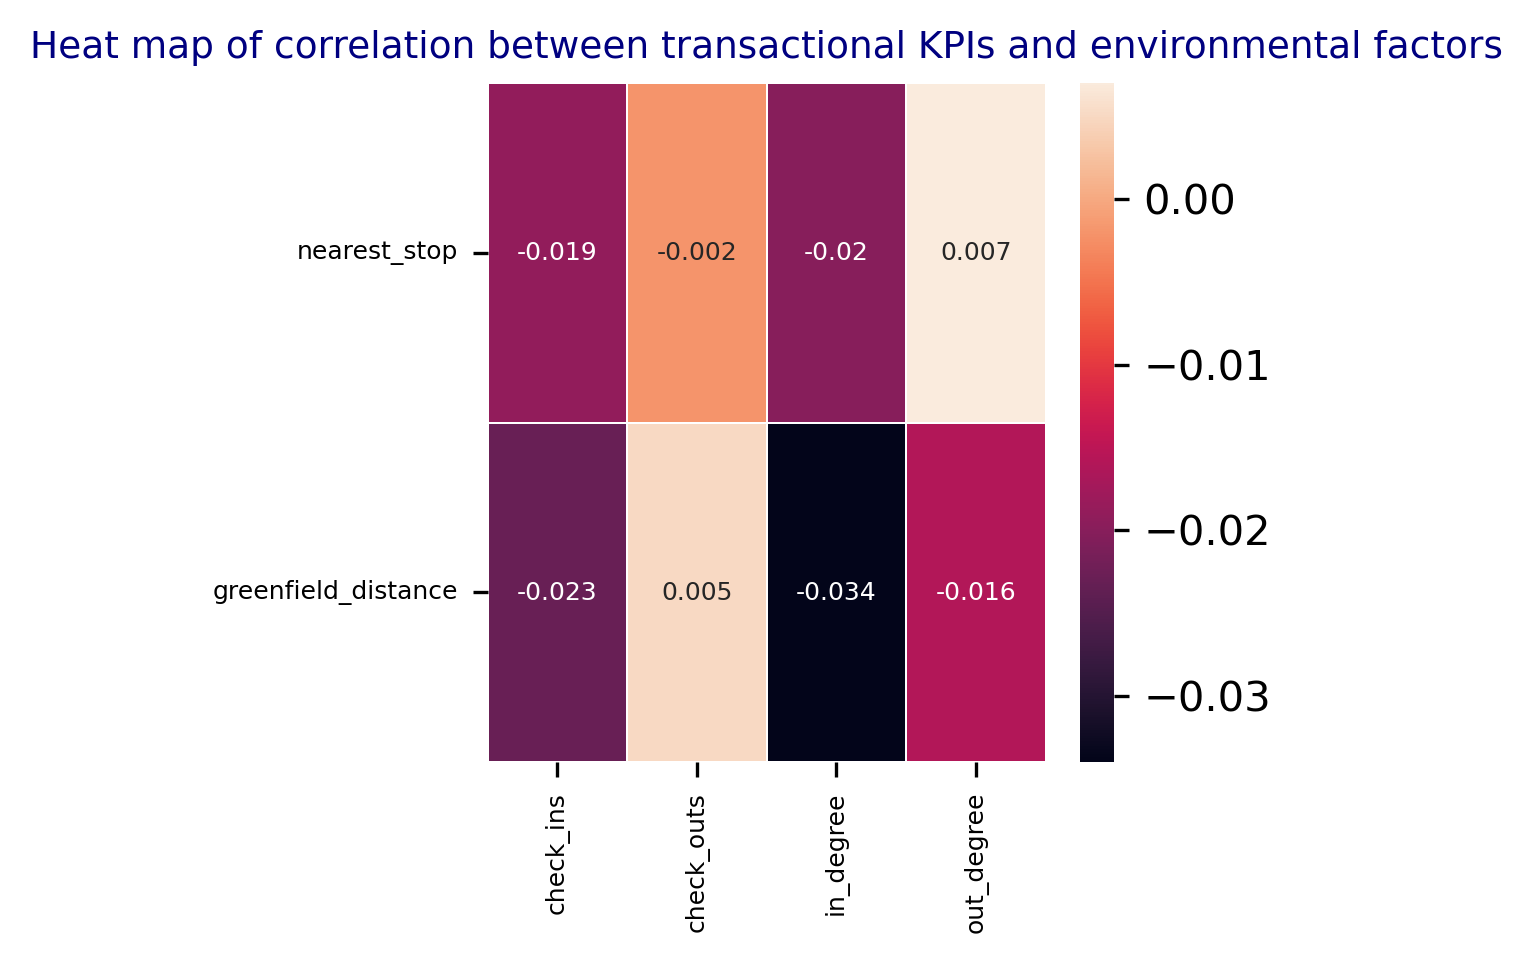

In [38]:
import seaborn as sns
fig,ax =plt.subplots(linewidth=1, figsize=(3,3), dpi=300)
sns.heatmap(corr_df.iloc[4:,:4],annot=True, linewidths=0.4,annot_kws={'size':6, 'weight':'normal'})
plt.title('Heat map of correlation between transactional KPIs and environmental factors', fontsize=9,color='navy',fontdict=dict(weight='normal'))
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0,fontsize=6)
plt.show()

In [39]:
%store vdf
vdf.to_file("../data/vdf.geojson", driver="GeoJSON")

Stored 'vdf' (GeoDataFrame)
